# 3.15. Modelo para predecir el rinde

La siguiente celda de código utiliza algunas de las bibliotecas más populares para el tratamiento y análisis de datos.

- `import numpy as np`: se importa la biblioteca `NumPy` y se le asigna un alias `np`, esto se hace para que sea más fácil de usar y escribir en el código. NumPy es una biblioteca que proporciona soporte para cálculos matemáticos y de matrices en Python.
- `import pandas as pd`: se importa la biblioteca `Pandas` y se le asigna un alias `pd`. Pandas es una biblioteca que proporciona estructuras de datos flexibles para el análisis de datos y herramientas para trabajar con datos estructurados.
- `import matplotlib.pyplot as plt`: se importa la biblioteca `Matplotlib`, que se utiliza para crear visualizaciones en Python, y se le asigna un alias `plt`.
- `%matplotlib inline`: se habilita la visualización en línea de gráficos `Matplotlib`, lo que significa que los gráficos se mostrarán directamente en el cuaderno de Jupyter en el que se está trabajando.
- `from sklearn.ensemble import RandomForestRegressor`: se importa la biblioteca `RandomForestRegressor` que se utiliza para crear modelos de regresión aleatorios que utilizan árboles de decisión. Estos modelos se utilizan a menudo para predecir valores numéricos a partir de características del conjunto de datos.
- `from sklearn.metrics import mean_squared_error, mean_absolute_error`: se importan algunas métricas de evaluación de modelos, incluyendo `mean_squared_error` y `mean_absolute_error`. Estas métricas se utilizan para evaluar el rendimiento del modelo en términos de precisión y ajuste.
- `from skforecast.ForecasterAutoreg import ForecasterAutoreg`: se importa la biblioteca `ForecasterAutoreg` que se especializa en modelos de predicción de series de tiempo en Python.
- `from statsmodels.iolib.smpickle import save_pickle`: se importa `save_pickle` que se utiliza para guardar modelos de predicción en archivos para su posterior uso.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

from skforecast.ForecasterAutoreg import ForecasterAutoreg

from statsmodels.iolib.smpickle import save_pickle

## Preparación de los datos

A continuación, en la siguiente celda de código, se presenta un conjunto de datos que fue creado manualmente utilizando información del Mirabueno. El conjunto de datos abarca un período de 36 años y se enfoca en la medición de el rinde de la lana y su correspondiente fecha.

In [2]:
datos = pd.read_csv('datos/lana_mirabueno_rinde.csv', sep=',')
datos

,fecha,rinde
0,1985-12-31,60.46
1,1986-12-31,61.52
2,1987-12-31,55.77
3,1988-12-31,61.69
4,1989-12-31,57.13
5,1990-12-31,59.84
6,1991-12-31,60.56
7,1992-12-31,54.04
8,1993-12-31,58.81
9,1994-12-31,61.83


En resumen, el siguiente código convierte la columna `fecha` en el índice, elimina la columna original, renombra la columna `rinde` como `y`, convierte los datos a una frecuencia anual y finalmente ordena los datos por el índice. El resultado final es un DataFrame limpio y organizado que puede ser utilizado para análisis de series de tiempo. La función `datos.head()` muestra las primeras cinco filas del DataFrame resultante.

In [3]:
datos = datos.set_index(pd.to_datetime(datos['fecha'], format='%Y/%m/%d')).drop(columns=['fecha']).rename(columns={'rinde': 'y'}).asfreq('A').sort_index()
datos.head()

,y
fecha,
1985-12-31,60.46
1986-12-31,61.52
1987-12-31,55.77
1988-12-31,61.69
1989-12-31,57.13


Las siguientes celdas utilizan las funciones max y min de Pandas para obtener el rango de valores del rinde.

In [4]:
datos['y'].max()

65.27

In [5]:
datos['y'].min()

53.1

El siguiente código verifica si el índice temporal del DataFrame (`datos`) está completo, es decir, si no faltan fechas entre la fecha mínima y la fecha máxima en el índice.

Para hacerlo, se crea un rango de fechas (`pd.date_range()`) que va desde la fecha mínima hasta la fecha máxima del índice, con la misma frecuencia que tiene el índice (`datos.index.freq`). Luego, se compara si todas las fechas del índice (`datos.index`) están presentes en este rango de fechas creado. Si esto es verdadero para todas las fechas, entonces se puede decir que el índice temporal está completo.

In [6]:
(datos.index == pd.date_range(
                    start = datos.index.min(),
                    end   = datos.index.max(),
                    freq  = datos.index.freq)
).all()

True

El siguiente código divide los datos en conjuntos de entrenamiento y prueba para su posterior uso en el modelado y la evaluación. En particular, se utiliza el parámetro `steps` para indicar la cantidad de puntos de datos que se deben reservar para el conjunto de prueba. Luego, se crea el conjunto de entrenamiento `datos_train` seleccionando todos los puntos de datos menos los últimos steps y el conjunto de prueba `datos_test` seleccionando los últimos steps puntos de datos.

In [7]:
steps = 3
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

La siguiente celda de código muestra un gráfico con los datos de entrenamiento y prueba. El eje x muestra las fechas en formato de años, con una separación de un año entre cada marca de tiempo. El eje y muestra el rinde de la lana.

`YearLocator()` es una función de la librería matplotlib.dates que determina las posiciones de las marcas de tiempo en el eje x. En este caso, se utiliza para establecer las marcas de tiempo en años.

`plt.style.use('ggplot')` se utiliza para aplicar el estilo 'ggplot' a la gráfica.

`ax.plot()` se utiliza para trazar los datos de entrenamiento en la gráfica.

`ax.scatter()` se utiliza para trazar los datos de prueba en la gráfica.

`ax.set_xlabel()` y `ax.set_ylabel()` se utilizan para establecer las etiquetas de los ejes x e y, respectivamente.

`ax.legend()` se utiliza para mostrar la leyenda de la gráfica.

`ax.xaxis.set_major_locator()` se utiliza para establecer el separación de las marcas de tiempo en el eje x.

`plt.xticks()` se utiliza para establecer la rotación y alineación de las marcas de tiempo en el eje x.

`ax.xaxis.set_major_formatter()` se utiliza para establecer el formato de las marcas de tiempo en el eje x.

Finalmente, se imprimen las fechas mínima y máxima de los conjuntos de entrenamiento y prueba junto con su longitud, utilizando `print()`.

Fechas train : 1985-12-31 00:00:00 --- 2017-12-31 00:00:00  (n=33)
Fechas test  : 2018-12-31 00:00:00 --- 2020-12-31 00:00:00  (n=3)


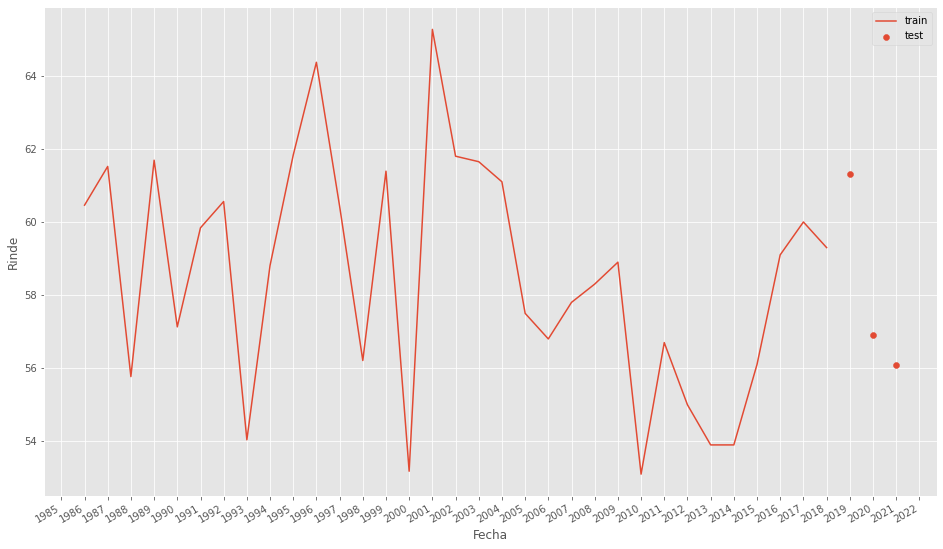

In [8]:
years = YearLocator()
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(datos_train.index, datos_train['y'], label='train')
ax.scatter(datos_test.index, datos_test['y'], label='test')
ax.set_xlabel('Fecha')
ax.set_ylabel('Rinde')
ax.legend()

ax.xaxis.set_major_locator(years)
plt.xticks(rotation=30, ha='right')
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

## Entrenar al modelo

Lo siguiente que hacemos es crear y entrenar un modelo de forecasting utilizando un `RandomForestRegressor` y la clase `ForecasterAutoreg` de la librería `skforecast`. Al establecer `random_state=123` en el modelo de `RandomForestRegressor`, se fija la semilla en 123 para la generación de los números aleatorios en el modelo, lo que permite que los resultados del modelo sean reproducibles. El modelo utiliza 24 lags (retrasos) como variables predictoras y se entrena con los datos de entrenamiento `datos_train`. Finalmente, se devuelve el modelo entrenado `forecaster`.

In [9]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 24
             )

forecaster.fit(y=datos_train['y'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1985-12-31 00:00:00'), Timestamp('2017-12-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: A-DEC 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-04-19 09:15:09 
Last fit date: 2023-04-19 09:15:09 
Skforecast version: 0.5.1 
Python version: 3.9.7 

A continuación se realizan predicciones de la serie temporal utilizando el modelo entrenado `forecaster` en la celda anterior. `steps` indica el número de periodos hacia adelante que se quieren predecir. El resultado es un array con las predicciones de la serie temporal.

In [10]:
steps = 3
predicciones = forecaster.predict(steps=steps)
predicciones

2018-12-31    57.834
2019-12-31    57.210
2020-12-31    56.714
Freq: A-DEC, Name: pred, dtype: float64

## Analizar resultados

En este caso, al utilizar un modelo de ForecasterAutoreg con RandomForestRegressor, se han elegido tres métricas para evaluar el modelo: MAE, MSE y RMSE. Se ha decidido no utilizar dos métricas que se venían utilizando previamente: R2 y Varianza explicada. Esto se debe a que el coeficiente de determinación (R2) es una medida común de la calidad de un modelo de regresión, pero puede no ser la medida más adecuada para evaluar un modelo de ForecasterAutoreg. En un modelo de predicción, el objetivo es predecir valores futuros y no ajustar los valores pasados. El R2 se basa en la comparación de los valores ajustados y observados en los datos de entrenamiento, lo que no es necesariamente una medida relevante para la capacidad del modelo para predecir valores futuros.

La varianza explicada, por otro lado, es una medida que indica cuánto de la varianza total de los datos puede explicarse mediante el modelo. Esta medida es útil para evaluar la capacidad del modelo para explicar la variabilidad en los datos. Sin embargo, en el caso de un modelo de predicción, esta medida puede no ser relevante, ya que lo importante es la capacidad del modelo para predecir valores futuros. En resumen, se han elegido las métricas más adecuadas para evaluar el modelo de predicción en cuestión y se han dejado de lado aquellas que no son relevantes para este propósito.

### Error medio absoluto

*Error medio absoluto* (**MAE**): Es la media de las diferencias absolutas entre el valor objetivo y el predicho. Al no elevar al cuadrado, no penaliza los errores grandes, lo que la hace no muy sensible a valores anómalos, por lo que no es una métrica recomendable en modelos en los que se deba prestar atención a éstos. Mientras mas cercano a cero mejor. Dentro de sklearn el método es **mean_absolute_error**.

In [11]:
'MAE: {:.2f} rinde'.format(mean_absolute_error(datos_test['y'], predicciones))

'MAE: 1.46 rinde'

*Interpretación:* El valor obtenido de 1.49 indica que, en promedio, las predicciones del modelo tienen un error absoluto medio de 1.49 en relación al valor real del rinde. Es decir, si tomamos cualquier predicción del modelo y la comparamos con el valor real correspondiente, en promedio la diferencia absoluta será de 1.49. En este caso, como el rango de valores del rinde va de 53.1 a 65.27, el MAE podría considerarse relativamente bueno en relación a la magnitud de los valores del rinde.

### Error cuadrático medio

*Error cuadrático medio* (**MSE**): Es la media de las diferencias entre el valor objetivo y el predicho al cuadrado. Al elevar al cuadrado los errores, magnifica los errores grandes, por lo que hay que utilizarla con cuidado cuando tenemos valores anómalos en nuestro conjunto de datos. Mientras mas cercano a cero mejor. Dentro de sklearn el método es **mean_squared_error**.

In [12]:
'MSE: {:.2f} rinde'.format(mean_squared_error(datos_test['y'], predicciones))

'MSE: 4.16 rinde'

*Interpretación:* un MSE de 4.64 indica que, en promedio, el modelo se equivoca en esa cantidad al predecir el rinde de la lana. En otras palabras, la diferencia entre los valores predichos y los valores reales del rinde, al ser elevados al cuadrado y promediados, resulta en un valor de 4.64. Al ser una medida cuadrática, penaliza más los errores grandes que los errores pequeños. Por lo tanto, el valor de 4.64 indica que el modelo puede estar teniendo dificultades para predecir correctamente los valores extremos del rango de valores del rinde.

### Raíz cuadrada del MSE

*Raíz cuadrada de la media del error al cuadrado* (**RMSE**): Es igual a la raíz cuadrada de la métrica anterior. La ventaja de esta métrica es que presenta el error en las mismas unidades que la variable objetivo, lo que la hace más fácil de entender. Mientras mas cercano a cero mejor. Dentro de sklearn el método es **mean_squared_error** con `squared = False`. 

In [13]:
'RMSE: {:.2f} rinde'.format(mean_squared_error(datos_test['y'], predicciones, squared = False))

'RMSE: 2.04 rinde'

*Interpretación:* un valor de 2.15 indica que, en promedio, las predicciones del modelo se desvían en 2.15 unidades de la medida de la variable objetivo (en este caso, el rinde de la lana). En este caso, dado que el rango de valores del rinde va de 53.1 a 65.27, una desviación de 2.15 unidades podría considerarse aceptable. 

El siguiente código genera un gráfico que muestra la serie de tiempo de los datos de entrenamiento (`datos_train['y']`) y luego agrega dos puntos de datos adicionales en el gráfico. Estos son los datos de prueba (`datos_test['y']`) representados por puntos rojos y las predicciones (`predicciones.values`) representadas por otro conjunto de puntos de color azul.

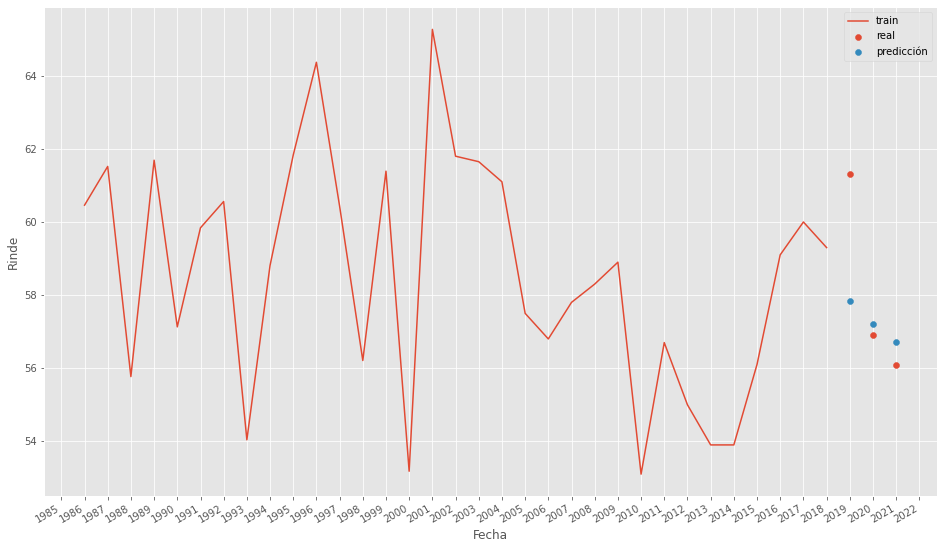

In [14]:
years = YearLocator()
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(datos_train.index, datos_train['y'], label='train')
ax.scatter(datos_test.index, datos_test['y'], label='real')
ax.scatter(predicciones.index, predicciones.values, label='predicción')
ax.set_xlabel('Fecha')
ax.set_ylabel('Rinde')
ax.legend()
ax.xaxis.set_major_locator(years)
plt.xticks(rotation=30, ha='right')
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y'))

El gráfico muestra que en general las predicciones del rinde fueron bastante aceptables, ya que dos de ellas están muy cerca del valor real. Sin embargo, para el año 2019 el modelo tuvo dificultades para predecir el rinde. Se podría considerar que este valor es casi extremo, y como indicó el MSE, el modelo tiende a tener dificultades para predecir este tipo de valores.

Finalmente guardamos el modelo para ser usado en la aplicación

In [15]:
save_pickle(forecaster,'modelos/modelo_prediccion_lana_rinde')